<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Stock_ML_TTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  3 of 3 completed


Price         Adj Close                                Close             \
Ticker             GC=F       SI=F       ^GDAXI         GC=F       SI=F   
Date                                                                      
2010-01-04  1117.699951  17.440001  6048.299805  1117.699951  17.440001   
2010-01-05  1118.099976  17.781000  6031.859863  1118.099976  17.781000   
2010-01-06  1135.900024  18.163000  6034.330078  1135.900024  18.163000   
2010-01-07  1133.099976  18.333000  6019.359863  1133.099976  18.333000   
2010-01-08  1138.199951  18.458000  6037.609863  1138.199951  18.458000   

Price                           High                                  Low  \
Ticker           ^GDAXI         GC=F       SI=F       ^GDAXI         GC=F   
Date                                                                        
2010-01-04  6048.299805  1122.300049  17.440001  6048.299805  1097.099976   
2010-01-05  6031.859863  1126.500000  17.820000  6058.020020  1115.000000   
2010-01-06  60

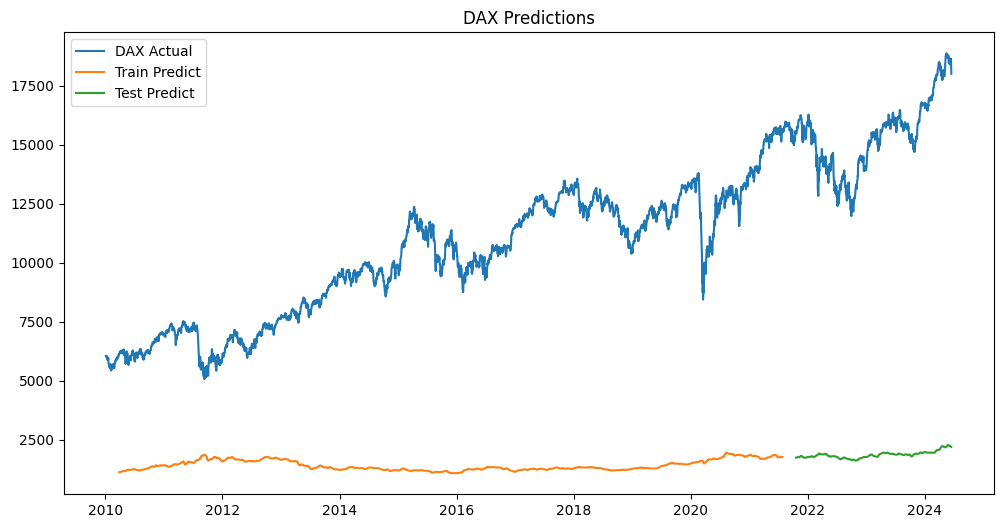

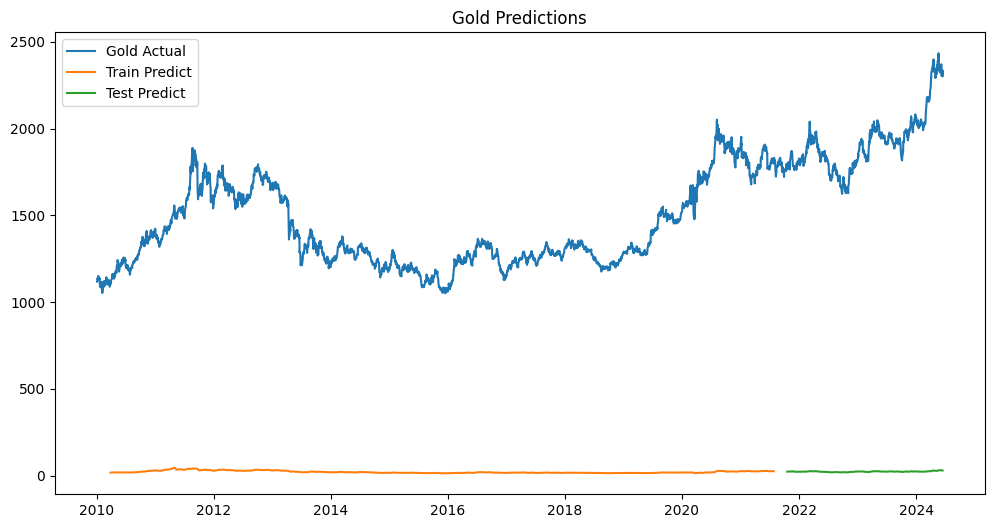

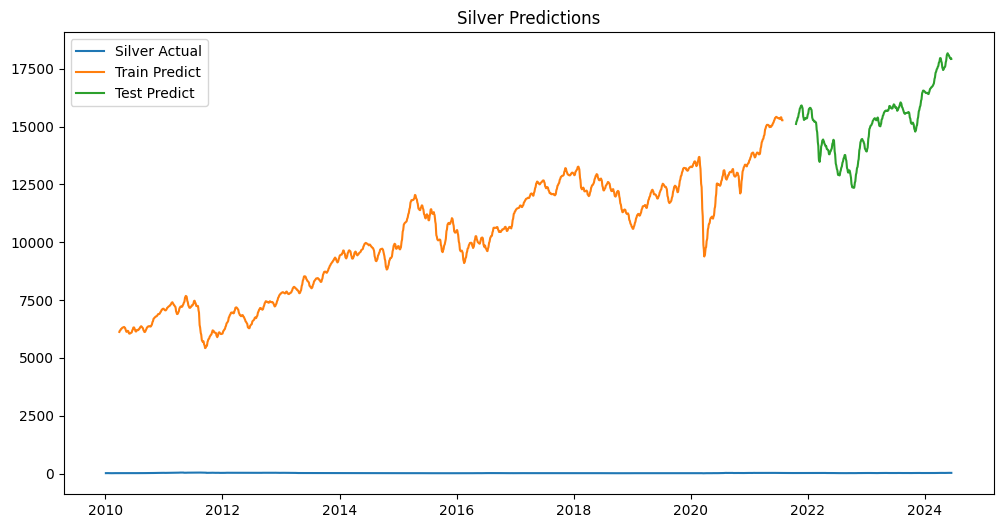

1/1 [==============================] - 0s 39ms/step
Next Day Prediction: [[ 2204.1404      29.550167 17890.709   ]]
Next 5 Days Prediction: [[ 2204.1404      29.550167 17890.709   ]
 [ 2197.825       29.411613 17830.057   ]
 [ 2188.8828      29.263933 17762.127   ]
 [ 2178.2815      29.112392 17688.654   ]
 [ 2166.628       28.95862  17611.107   ]]
Advice for Next Day: ['Hold', 'Hold', 'Hold']
Advice for Next 5 Days: ['Hold', 'Sell', 'Hold']


In [2]:
# Import necessary libraries
!pip install tensorflow yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

# Set end date to today
end_date = datetime.today().strftime('%Y-%m-%d')

# Download data from Yahoo Finance
symbols = ['^GDAXI', 'GC=F', 'SI=F']
data = yf.download(symbols, start='2010-01-01', end=end_date)

# Fill missing values
data = data.fillna(method='ffill')

# Display the first few rows
print(data.head())

# Preprocessing
adj_close = data['Adj Close']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(adj_close)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create a function to detect block orders
def detect_block_orders(data, volume_threshold=1.5, price_change_threshold=0.02):
    block_orders = pd.DataFrame(index=data.index)
    for col in data['Adj Close'].columns:
        avg_volume = data['Volume'][col].rolling(window=20).mean()
        avg_price_change = data['Adj Close'][col].pct_change().rolling(window=20).mean()

        block_orders[col + ' Volume Signal'] = data['Volume'][col] > (avg_volume * volume_threshold)
        block_orders[col + ' Price Change Signal'] = data['Adj Close'][col].pct_change() > avg_price_change * price_change_threshold
        block_orders[col + ' Block Order'] = block_orders[col + ' Volume Signal'] & block_orders[col + ' Price Change Signal']

    return block_orders

# Detect block orders
block_orders = detect_block_orders(data)

# Create a function to create datasets for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, :])
    return np.array(X), np.array(Y)

# Define time step
time_step = 60

# Create training and testing datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], time_step, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], time_step, X_test.shape[2])

# Create LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

# Adjust the lengths for plotting
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2):len(scaled_data), :] = test_predict

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index, adj_close['^GDAXI'], label='DAX Actual')
plt.plot(data.index, train_plot[:, 0], label='Train Predict')
plt.plot(data.index, test_plot[:, 0], label='Test Predict')
plt.title('DAX Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, adj_close['GC=F'], label='Gold Actual')
plt.plot(data.index, train_plot[:, 1], label='Train Predict')
plt.plot(data.index, test_plot[:, 1], label='Test Predict')
plt.title('Gold Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index, adj_close['SI=F'], label='Silver Actual')
plt.plot(data.index, train_plot[:, 2], label='Train Predict')
plt.plot(data.index, test_plot[:, 2], label='Test Predict')
plt.title('Silver Predictions')
plt.legend()
plt.show()

# Predict for the next day and next 5 days
def predict_future(model, last_data, time_step, days):
    predictions = []
    input_data = last_data[-time_step:].reshape(1, time_step, last_data.shape[1])
    for _ in range(days):
        pred = model.predict(input_data)
        predictions.append(pred)
        input_data = np.append(input_data[:, 1:, :], pred.reshape(1, 1, last_data.shape[1]), axis=1)
    return scaler.inverse_transform(np.array(predictions).reshape(days, last_data.shape[1]))

last_data = scaled_data[-time_step:]
next_day_prediction = predict_future(model, last_data, time_step, 1)
next_5_days_prediction = predict_future(model, last_data, time_step, 5)

print("Next Day Prediction:", next_day_prediction)
print("Next 5 Days Prediction:", next_5_days_prediction)

# Create advice function based on predictions and block orders
def create_advice(current_price, future_price, block_order):
    advice = []
    for curr, fut, block in zip(current_price, future_price, block_order):
        if fut > curr * 1.01:
            advice.append('Buy' if block else 'Hold')
        elif fut < curr * 0.99:
            advice.append('Sell' if block else 'Hold')
        else:
            advice.append('Hold')
    return advice

current_price = scaler.inverse_transform(scaled_data[-1].reshape(1, -1))
block_order = block_orders.iloc[-1].values

advice_next_day = create_advice(current_price[0], next_day_prediction[0], block_order)
advice_next_5_days = create_advice(current_price[0], next_5_days_prediction[-1], block_order)

print("Advice for Next Day:", advice_next_day)
print("Advice for Next 5 Days:", advice_next_5_days)

##########

# Print the predictions and advice with clear references to the assets
assets = ['DAX', 'Gold', 'Silver']

print("Next Day Prediction:")
for asset, prediction in zip(assets, next_day_prediction[0]):
    print(f"{asset}: {prediction}")

print("\nNext 5 Days Prediction:")
for day, predictions in enumerate(next_5_days_prediction, start=1):
    print(f"Day {day}:")
    for asset, prediction in zip(assets, predictions):
        print(f"  {asset}: {prediction}")

print("\nAdvice for Next Day:")
for asset, advice in zip(assets, advice_next_day):
    print(f"{asset}: {advice}")

print("\nAdvice for Next 5 Days:")
for asset, advice in zip(assets, advice_next_5_days):
    print(f"{asset}: {advice}")
